# Prueba práctica python y Machine Learning

### Este proyecto tiene como objetivo calcular la probabilidad de default de un cliente

### Proceso de ETL

Primero importo las librerias a usar

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import randint, uniform
from collections import Counter
from sklearn.ensemble import VotingClassifier



Ahora, procedo a importar el archivo 'clientes.csv'

### ***EXTRACCIÓN***

In [2]:
df = pd.read_csv(r'C:\Users\Cristian\Desktop\PRUEBA\PuntoRed\Data\clientes.csv')

### ***TRANSFORMACIÓN***

Realizaré algunas funciones con el objetivo de analizar completamente el dataset e identificar transformaciones que deberian ser hechas para cumplir con el objetivo de este proyecto.

Primero, procederemos a verificar datos nulos.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   edad                  1000 non-null   int64
 1   ingreso_mensual       1000 non-null   int64
 2   historial_crediticio  1000 non-null   int64
 3   default               1000 non-null   int64
dtypes: int64(4)
memory usage: 31.4 KB


In [4]:
df.isnull().sum()

edad                    0
ingreso_mensual         0
historial_crediticio    0
default                 0
dtype: int64

El dataset está completo. No hay valores nulos.

Se procederá a ver valores duplicados.

In [5]:
print(df.duplicated().sum()) # No hay valores duplicados

0


Revisaré cada variable para encontrar valores fuera de rango.

In [6]:
df.describe().round(2)

,edad,ingreso_mensual,historial_crediticio,default
count,1000.00,1000.00,1000.00,1000.00
mean,44.38,5966.97,2.54,0.15
std,15.32,2306.04,1.70,0.36
min,18.00,2002.00,0.00,0.00
25%,31.75,4034.50,1.00,0.00
50%,45.00,5922.00,3.00,0.00
75%,57.00,7920.00,4.00,0.00
max,70.00,9997.00,5.00,1.00


El dataset no contiene valores fuera de rango.

- Los valores de edad se encuentran en 18 y 70, lo cual es normal.
- Lo valores de historial crediticio se encuentran entre 0 y 5.
- Valor de default entre 0 y 1

Debido al contexto bancario no elimianre outliers.

Veo que es necesaria una normalización en la variable de ingreso_mensual. Sin embargo, mas adelante me centraré en ello en la etapa de construcción del modelo.

# **EDA**

Ahora, procederé a realizar un analisis estadistico con el fin de analizar el dataset.

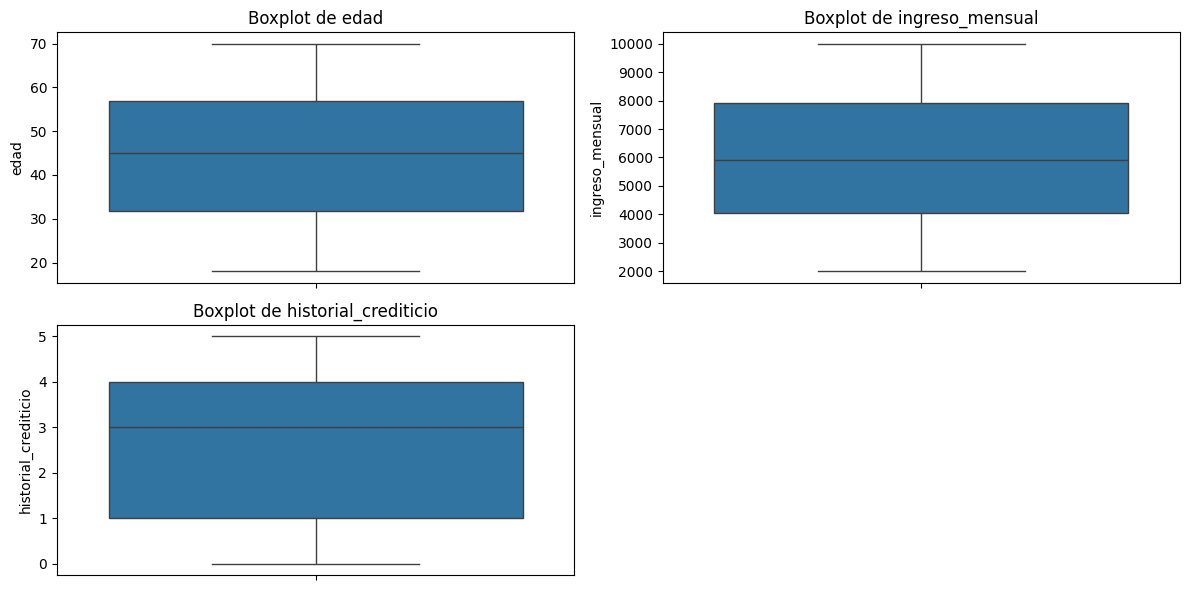

In [7]:
# Primero filtro las columnas numericas (Todas son numericas pero es una buena practica hacerlo) (excluyo default)
numeric_columns = [col for col in df.select_dtypes(include=['number']).columns if col != 'default']

# Creo subplots en 2 columnas
fig, axes = plt.subplots(nrows=len(numeric_columns) // 2 + len(numeric_columns) % 2, ncols=2, figsize=(12, 4 * len(numeric_columns) // 2))

# Paso el arreglo a unidimensional
axes = axes.flatten()

#  Hago un bucle para que recorra cada variable y grafique un boxplot para poder entender la distribucion de la variable
for i, column in enumerate(numeric_columns):
    sns.boxplot(y=df[column], ax=axes[i])
    axes[i].set_title(f'Boxplot de {column}')
    axes[i].set_ylabel(column)

# Oculto ejes vacíos si el número de gráficos no es par
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()



***Análisis de los Boxplots***

**Boxplot de Edad:**

La mediana de la edad parece estar alrededor de los 45-50 años.
El IQR muestra que el 50% central de las edades está entre aproximadamente 35 y 60 años.
La edad minima esta alrededor de los 20 años y la maxima cerca de los 70.

**Boxplot de Ingreso Mensual:**

La mediana del ingreso mensual parece estar alrededor de los 5000-6000.
El IQR muestra que el 50% central de los ingresos está entre aproximadamente 3000 y 8000.
Se aprecia que la mayoria de los ingresos se encuentran en el rango de los 2000 a los 9000 aproximadamente.
La distribución del ingreso mensual parece ser un poco asimétrica, con una cola más larga hacia ingresos más altos.

**Boxplot de Historial Crediticio:**

Este boxplot muestra una distribución más discreta.
La mediana está alrededor de 3.
El rango intercuartílico muestra que el 50% central de los historiales crediticios está entre aproximadamente 2 y 4.
Se aprecia que la mayoria del historial crediticio se encuentra entre 1 y 4.


Ahora, procederé a graficar la distribucion de los datos usando ***Histogramas***.

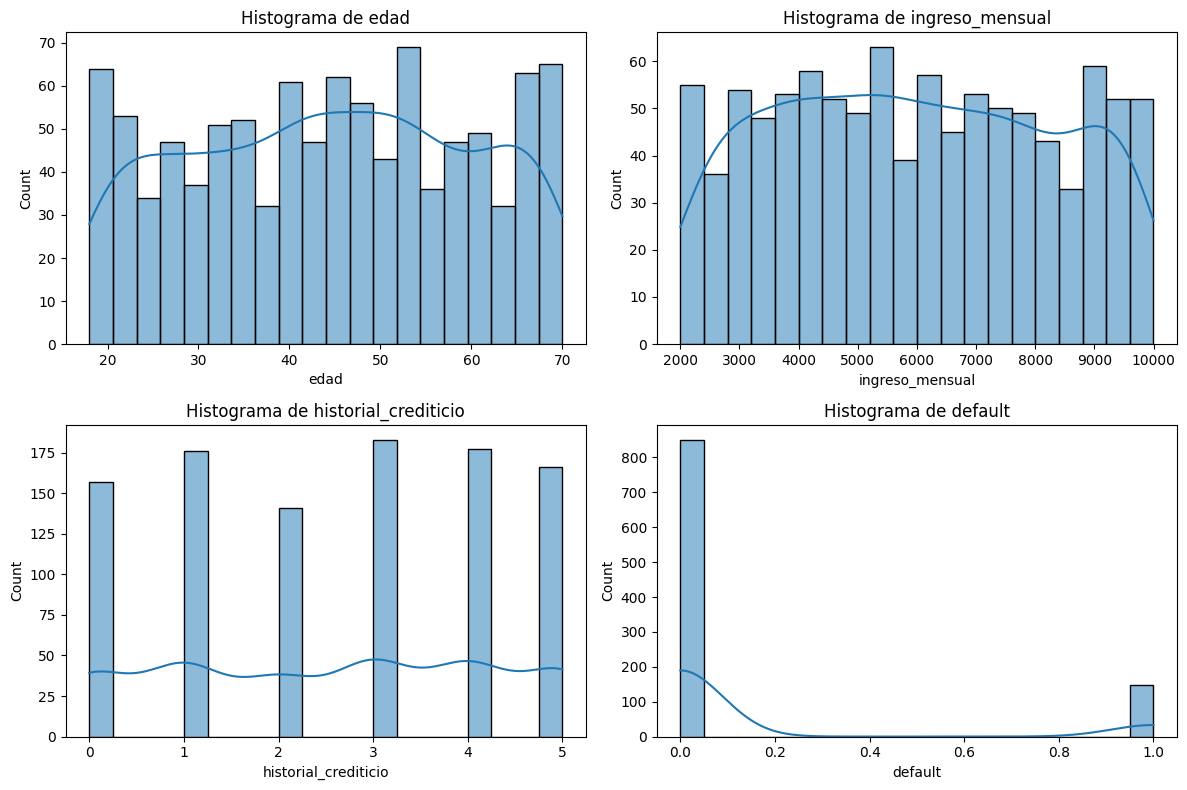

In [8]:
# Filtrar columnas numéricas (buena práctica)
numeric_columns = [col for col in df.select_dtypes(include=['number']).columns]

#  Creo subplots en 2 columnas
fig, axes = plt.subplots(nrows=len(numeric_columns) // 2 + len(numeric_columns) % 2, 
                         ncols=2, figsize=(12, 4 * len(numeric_columns) // 2))

# Paso el arreglo a unidimensional
axes = axes.flatten()

# Hago un bucle para graficar histogramas por cada variable
for i, column in enumerate(numeric_columns):
    sns.histplot(x=df[column], bins=20, kde=True, ax=axes[i])
    axes[i].set_title(f'Histograma de {column}')
    axes[i].set_xlabel(column)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


### ***Conclusiones del gráfico:***
**Distribución de las variables numéricas**

Edad: Parece estar uniformemente distribuida, con valores entre aproximadamente 18 y 70 años.
Ingreso mensual: Tiene una distribución relativamente uniforme, aunque con ciertas fluctuaciones.
Default: La mayoría de los clientes tienen valor 0 (no incumplen), y solo una pequeña proporción tiene 1 (sí incumplen). Se evidencia un desbalance. A la hora de entrenar el modelo tomaré las acciones correspondientes (oversmapling, undersampling o stratify)

**Correlación**
Ahora procederé a calcular la correlación de cada variable frente al target (default) y asi encontrar las que definen en mayor magintud a la variable objetivo.

In [9]:
correlaciones = df.corr()

In [10]:
correlaciones['default'].sort_values(ascending=False)

default                 1.000000
edad                    0.023589
ingreso_mensual        -0.250538
historial_crediticio   -0.327310
Name: default, dtype: float64

Aqui se pueden observar las variables organizadas por la magnitud de su correlación.
- La variable 'historial_crediticio' representa la correlación mas fuerte de naturalreza **negativa**

Ahora procederemos a graficarlo para facilitar su entendimiento.

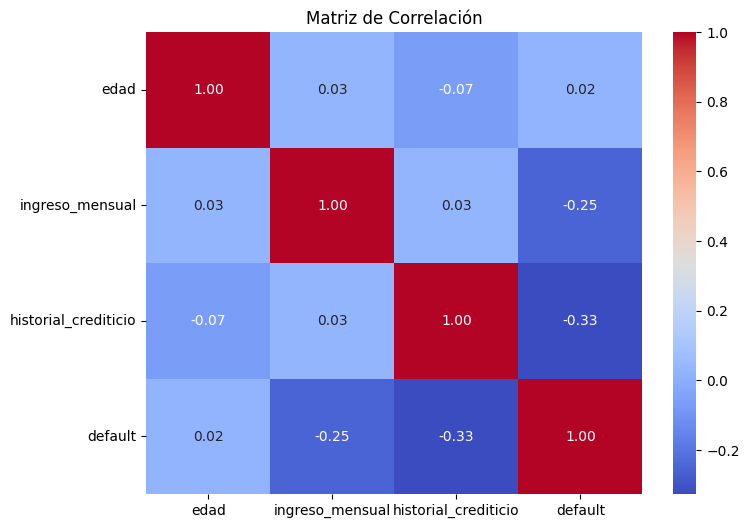

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

En esta matriz de correlación se evidencia las conclusiones anteriormente mencionadas. De igual manera, se puede inferir que no existe una fuerte multicolinealidad entre las caracteristicas independientes.

Ahora graficaré **histogramas** para visualizar la distribución de cada variable, diferenciando los valores según la variable default (1 o 0). Si una variable tiene una correlación fuerte con default, es esperable que sus distribuciones sean más distintas entre ambos grupos. En cambio, si la correlación es débil, ambas distribuciones serán más similares.

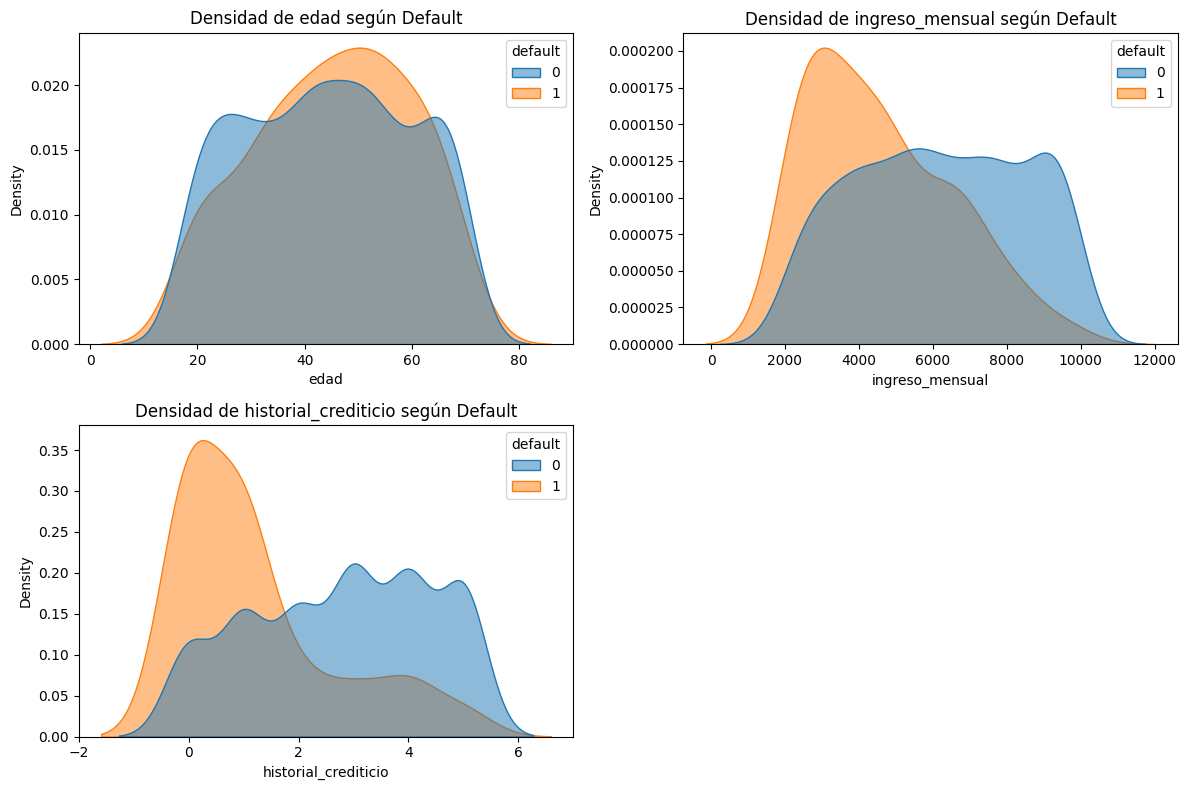

In [12]:
# Defino las columnas a graficar
columns = ['edad', 'ingreso_mensual', 'historial_crediticio']

# Creo subplots para que se vea en dos columnas
fig, axes = plt.subplots(nrows=len(columns) // 2 + len(columns) % 2, ncols=2, figsize=(12, 8))

# Transformo a unidimensional
axes = axes.flatten()

# Itero sobre las columnas y grafico las curvas de densidad
for i, column in enumerate(columns):
    sns.kdeplot(data=df, x=column, hue='default', fill=True, common_norm=False, alpha=0.5, ax=axes[i])
    axes[i].set_title(f"Densidad de {column} según Default")

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Esta sección fue relevante ya que no solamente me permitió entender la distribución de las variables sino que tambien identificar aquellas que tienen una correlación mas fuerte, y que por ende explican en mayor medida a la variable target ('Default')

# ***Machine Learning***

Para esta sección utilziaré diversas herramientas y modelos con el objetivo de encontrar el mejor modelo.
Utilizaré 3 modelos supervisados de clasificación:
- ***Random Forest***:
   - Es robusto y maneja bien datos no lineales.
   - Puede manejar el desbalanceo de clases usando parámetros como class_weight.
   - Proporciona el Feature Importance, lo cual me permite identificar el peso de cada variable en el modelo.
- ***XG Boost***:
   - Es uno de los modelos más efectivos para problemas de clasificación.(al ser secuencial y manejar el gradient descence)
   - Maneja muy bien el desbalanceo de clases usando el parámetro scale_pos_weight
- ***Regresion logistica***:
   - Es un modelo simple y rápido.
   - Puede manejar el desbalanceo usando el parámetro class_weight.
   - Al ser simple su interpretación es mas sencilla
  

Tambien usaré oversampling, undersampling y stratify para manejar el desbalanceo de clases. (De igual manera entrenaré el modelo con datos escalados o normalizados)

## **Random Forest**


## **Random Forest con Hiperparametros**

In [13]:
# Defino las variables independientes (X) y la variable dependiente (y)
X = df[['edad', 'ingreso_mensual', 'historial_crediticio']]  # Características
y = df['default']  # Variable objetivo

# Se dividen los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# tamaño de los conjuntos de entrenamiento y prueba
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

# Definición de hiperparámetros a ajustar
param_dist = {
    'n_estimators': randint(100, 500),  # Número de árboles
    'max_depth': [None, 10, 20, 30],  # Profundidad máxima de los árboles
    'min_samples_split': randint(2, 20),  # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': randint(1, 20),  # Mínimo de muestras en una hoja
    'class_weight': ['balanced', None]  # Peso de las clases
}

# modelo de Random Forest
model = RandomForestClassifier(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=100,  # Prueba solo 100 combinaciones
    cv=4,  # Validación cruzada de 2 folds
    scoring='f1',  # Métrica a optimizar (F1-score)
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos del CPU
)

# Se ajusta el modelo con RandomizedSearchCV
random_search.fit(X_train, y_train)

# mejores hiperparámetros
print("\nMejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Prediccion con el conjunto de prueba usando el mejor modelo
y_pred = random_search.predict(X_test)
best_random = random_search.best_estimator_ # Guardo el modelo en una variable
# Evaluación el modelo
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# AUC-ROC
y_pred_prob = best_random.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"\nAUC-ROC: {roc_auc:.4f}")


Tamaño del conjunto de entrenamiento: 800 muestras
Tamaño del conjunto de prueba: 200 muestras

Mejores hiperparámetros encontrados:
{'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 3, 'n_estimators': 372}

Matriz de confusión:
[[155  15]
 [  9  21]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       170
           1       0.58      0.70      0.64        30

    accuracy                           0.88       200
   macro avg       0.76      0.81      0.78       200
weighted avg       0.89      0.88      0.88       200


AUC-ROC: 0.8359


### **RANDOM FOREST**
***Metodo de balanceo SMOTE (oversampling)***

In [36]:
pipeline_smote = Pipeline([
    ('smote', SMOTE(random_state=42)),  # Oversampling de la clase minoritaria
    ('model', best_random)  # Usar el mejor modelo de Random Forest
])

# Se entrena el pipeline con SMOTE y Undersampling
pipeline_smote.fit(X_train, y_train)

# Predecicción con el conjunto de prueba
y_pred_smote = pipeline_smote.predict(X_test)

# Evaluación del modelo
print("\nMatriz de confusión (SMOTE):")
print(confusion_matrix(y_test, y_pred_smote))

print("\nReporte de clasificación (SMOTE + Undersampling):")
print(classification_report(y_test, y_pred_smote))

# AUC-ROC
y_pred_prob = best_random.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"\nAUC-ROC: {roc_auc:.4f}")


Matriz de confusión (SMOTE):
[[145  25]
 [  8  22]]

Reporte de clasificación (SMOTE + Undersampling):
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       170
           1       0.47      0.73      0.57        30

    accuracy                           0.83       200
   macro avg       0.71      0.79      0.73       200
weighted avg       0.88      0.83      0.85       200


AUC-ROC: 0.8490


### **RANDOM FOREST**
***Metodo de balanceo Undersampling***

In [15]:
# pipeline con RandomUnderSampler y el mejor modelo
pipeline_under = Pipeline([
    ('undersample', RandomUnderSampler(random_state=42)),  # Undersampling de la clase mayoritaria
    ('model', best_random)  # Usar el mejor modelo de Random Forest
])

# pipeline con Undersampling
pipeline_under.fit(X_train, y_train)

# Se extraen los datos después del undersampling
X_train_under, y_train_under = pipeline_under.named_steps['undersample'].fit_resample(X_train, y_train)

# balance de clases después del undersampling
print("\nBalance de clases después del undersampling:")
print("Clase 0 (No default):", Counter(y_train_under)[0])
print("Clase 1 (Default):", Counter(y_train_under)[1])

# Predecición con el conjunto de prueba
y_pred_under = pipeline_under.predict(X_test)

# Evaluación del modelo
print("\nMatriz de confusión (Undersampling):")
print(confusion_matrix(y_test, y_pred_under))

print("\nReporte de clasificación (Undersampling):")
print(classification_report(y_test, y_pred_under))

# AUC-ROC
y_pred_prob = best_random.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"\nAUC-ROC: {roc_auc:.4f}")


Balance de clases después del undersampling:
Clase 0 (No default): 119
Clase 1 (Default): 119

Matriz de confusión (Undersampling):
[[148  22]
 [  8  22]]

Reporte de clasificación (Undersampling):
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       170
           1       0.50      0.73      0.59        30

    accuracy                           0.85       200
   macro avg       0.72      0.80      0.75       200
weighted avg       0.88      0.85      0.86       200


AUC-ROC: 0.8227


### ***Como conclusión podemos observar que el Random Forest (en este caso) funciona mucho mejor utilizando como metodo de balanceo 'class_weight'. Esto basado en las métricas presentadas en cada modelo previamente entrenado.***

## ***XGBOOST***

## **XG BOOST Hiperparametriazcion**

In [16]:
# Definición de las variables independientes (X) y la variable dependiente (y)
X = df[['edad', 'ingreso_mensual', 'historial_crediticio']]  # Características
y = df['default']  # Variable objetivo

# Division de los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Definir los hiperparámetros a ajustar
param_dist = {
    'model__n_estimators': randint(100, 500),  # Número de árboles
    'model__max_depth': randint(3, 10),  # Profundidad máxima de los árboles
    'model__learning_rate': uniform(0.01, 0.3),  # Tasa de aprendizaje
    'model__subsample': uniform(0.6, 0.4),  # Submuestra de instancias para entrenar cada árbol
    'model__colsample_bytree': uniform(0.6, 0.4),  # Submuestra de características para cada árbol
    'model__gamma': uniform(0, 0.5),  # Reducción mínima de pérdida para hacer una división
    'model__scale_pos_weight': [1, (len(y_train) - sum(y_train)) / sum(y_train)]  # Peso de la clase positiva
}

# pipeline con SMOTE y XGBoost
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),  # Oversampling de la clase minoritaria
    ('model', XGBClassifier(random_state=42))  # Modelo de XGBoost
])

# randomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=100,  # Número de combinaciones de hiperparámetros a probar
    cv=4,  # Validación cruzada de 3 folds
    scoring='f1',  # Métrica a optimizar (F1-score)
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos del CPU
)

# Ajustde del modelo con RandomizedSearchCV
random_search.fit(X_train, y_train)

# mejores hiperparámetros
print("\nMejores hiperparámetros encontrados:")
print(random_search.best_params_)

best_xg = random_search.best_estimator_ # Guardo el mejor modelo 

# Predección con el conjunto de prueba usando el mejor modelo
y_pred = random_search.predict(X_test)

# Evaluación del modelo
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# AUC-ROC
y_pred_prob = best_xg.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"\nAUC-ROC: {roc_auc:.4f}")


Mejores hiperparámetros encontrados:
{'model__colsample_bytree': 0.9166316174903394, 'model__gamma': 0.39480907139727694, 'model__learning_rate': 0.03736183091460711, 'model__max_depth': 4, 'model__n_estimators': 285, 'model__scale_pos_weight': 1, 'model__subsample': 0.9983724968121317}

Matriz de confusión:
[[147  23]
 [  8  22]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       170
           1       0.49      0.73      0.59        30

    accuracy                           0.84       200
   macro avg       0.72      0.80      0.75       200
weighted avg       0.88      0.84      0.86       200


AUC-ROC: 0.8491


## **XGBoost** 
### **Con metodo de balanceo (oversampling)**

In [17]:
# pipeline con RandomUnderSampler y el mejor modelo
pipeline_under = Pipeline([
    ('undersample', RandomUnderSampler(random_state=42)),  # Undersampling de la clase mayoritaria
    ('model', best_xg)  # Usar el mejor modelo de Random Forest
])

# Entrenamiento del pipeline con Undersampling
pipeline_under.fit(X_train, y_train)

# Extraccion de los datos después del undersampling
X_train_under, y_train_under = pipeline_under.named_steps['undersample'].fit_resample(X_train, y_train)

# balance de clases después del undersampling
print("\nBalance de clases después del undersampling:")
print("Clase 0 (No default):", Counter(y_train_under)[0])
print("Clase 1 (Default):", Counter(y_train_under)[1])

# Predecccion con el conjunto de prueba
y_pred_under = pipeline_under.predict(X_test)

# Evaluacion del modelo
print("\nMatriz de confusión (Undersampling):")
print(confusion_matrix(y_test, y_pred_under))

print("\nReporte de clasificación (Undersampling):")
print(classification_report(y_test, y_pred_under))

# AUC-ROC
y_pred_prob = best_random.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"\nAUC-ROC: {roc_auc:.4f}")


Balance de clases después del undersampling:
Clase 0 (No default): 119
Clase 1 (Default): 119

Matriz de confusión (Undersampling):
[[137  33]
 [  7  23]]

Reporte de clasificación (Undersampling):
              precision    recall  f1-score   support

           0       0.95      0.81      0.87       170
           1       0.41      0.77      0.53        30

    accuracy                           0.80       200
   macro avg       0.68      0.79      0.70       200
weighted avg       0.87      0.80      0.82       200


AUC-ROC: 0.8227


### ***Como conclusión podemos observar que el modelo XG Boost (en este caso) funciona mucho mejor utilizando como metodo de balanceo 'model__scale_pos_weight'. Esto basado en las métricas presentadas en cada modelo previamente entrenado.***

# ***Regresion Logistica***
## **Hyperparametrización**

In [18]:

X = df[['edad', 'ingreso_mensual', 'historial_crediticio']]  # Características
y = df['default']  # Variable objetivo

# Division los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Definicion de los hiperparámetros a ajustar
param_dist = {
    'C': uniform(0.01, 200),  # Parámetro de regularización (inverso de la fuerza de regularización)
    'penalty': ['l1', 'l2'],  # Tipo de regularización
    'solver': ['liblinear'],  # Algoritmo de optimización (soporta l1 y l2)
    'class_weight': [None, 'balanced']  # Peso de las clases
}

#  modelo de Regresión Logística
model = LogisticRegression(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=300,  # Número de combinaciones de hiperparámetros a probar
    cv=4,  # Validación cruzada de 4 folds
    scoring='f1',  # Métrica a optimizar (F1-score)
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos del CPU
)

# Ajuste del modelo con RandomizedSearchCV
random_search.fit(X_train, y_train)

# mejores hiperparámetros
print("\nMejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Prediccion con el conjunto de prueba usando el mejor modelo
y_pred = random_search.predict(X_test)

best_logistic = random_search.best_estimator_

# Evaluacion del modelo
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))
best_logistic = random_search.best_estimator_
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# AUC-ROC
y_pred_prob = best_logistic.predict_proba(X_test)[:, 1] 
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"\nAUC-ROC: {roc_auc:.4f}")


Mejores hiperparámetros encontrados:
{'C': 1.0223167692437374, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

Matriz de confusión:
[[134  36]
 [  6  24]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.96      0.79      0.86       170
           1       0.40      0.80      0.53        30

    accuracy                           0.79       200
   macro avg       0.68      0.79      0.70       200
weighted avg       0.87      0.79      0.81       200


AUC-ROC: 0.8178


### **Normalización**

In [19]:
df_copy = df.copy()

In [20]:

# Escalamiento de los datos con MinMaxScaler
scaler = MinMaxScaler()

# Hacer que la columna 'ingreso_mensual' sea un df de una sola columna
df_copy['ingreso_mensual'] = scaler.fit_transform(df_copy[['ingreso_mensual']])
df_copy.head()

,edad,ingreso_mensual,historial_crediticio,default
0,56,0.037523,4,0
1,69,0.079550,3,0
2,46,0.006629,4,0
3,32,0.602752,4,0
4,60,0.065416,0,1


In [21]:
X = df_copy[['edad', 'ingreso_mensual', 'historial_crediticio']]  # Características
y = df_copy['default']  # Variable objetivo

# Dividision de los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# conjuntos de entrenamiento y prueba
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

# Ajuste del modelo
best_logistic.fit(X_train, y_train)

# predicciones en el conjunto de prueba
y_pred = best_logistic.predict(X_test)

# Evaluacion del modelo
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# AUC-ROC
y_pred_prob = best_logistic.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"\nAUC-ROC: {roc_auc:.4f}")

Tamaño del conjunto de entrenamiento: 800 muestras
Tamaño del conjunto de prueba: 200 muestras

Matriz de confusión:
[[133  37]
 [  6  24]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.96      0.78      0.86       170
           1       0.39      0.80      0.53        30

    accuracy                           0.79       200
   macro avg       0.68      0.79      0.69       200
weighted avg       0.87      0.79      0.81       200


AUC-ROC: 0.8200


 ## ***Regresion Logistica con Balanceo***

**SMOTE**

In [22]:
X = df_copy[['edad', 'ingreso_mensual', 'historial_crediticio']]  # Características
y = df_copy['default']  # Variable objetivo

# Division los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# tamaño de los conjuntos de entrenamiento y prueba
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

# Aplico SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Tamaño del conjunto de entrenamiento con SMOTE: {X_train_res.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba con SMOTE: {y_train_res.shape[0]} muestras")

# Definicion y ajuste del modelo (aquí asumo que tienes un modelo de regresión logística)
best_logistic.fit(X_train_res, y_train_res)

# predicciones en el conjunto de prueba
y_pred = best_logistic.predict(X_test)

# Evaluacion del modelo
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# AUC-ROC
y_pred_prob = best_logistic.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"\nAUC-ROC: {roc_auc:.4f}")

Tamaño del conjunto de entrenamiento: 800 muestras
Tamaño del conjunto de prueba: 200 muestras
Tamaño del conjunto de entrenamiento con SMOTE: 1362 muestras
Tamaño del conjunto de prueba con SMOTE: 1362 muestras

Matriz de confusión:
[[146  24]
 [  7  23]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       170
           1       0.49      0.77      0.60        30

    accuracy                           0.84       200
   macro avg       0.72      0.81      0.75       200
weighted avg       0.88      0.84      0.86       200


AUC-ROC: 0.8271


### ***Como conclusión podemos observar que el modelo de Regresion Logistica (en este caso) funciona mucho mejor utilizando la normalización en aquellas variables donde la brecha entre las isntancias es grande. De igual manera, el modelo funciona mejor aplicando el metodo de balanceo 'oversampling'. Esto basado en las métricas presentadas en cada modelo previamente entrenado.***

In [23]:
best_xg

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9166316174903394, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.39480907139727694,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.03736183091460711, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=285,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))])

In [24]:
best_logistic

LogisticRegression(C=1.0223167692437374, class_weight='balanced',
                   random_state=42, solver='liblinear')

In [25]:
best_random

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, min_samples_split=3,
                       n_estimators=372, random_state=42)

### ***VOTING CLASIFIER***

### **A continuación, utilizare un voting classifier con el objetivo de como entrada varios modelos entrenados y, en función del tipo de votación (oft, probabilidad), hace una predicción combinando las salidas de esos modelos.**

In [26]:
X = df[['edad', 'ingreso_mensual', 'historial_crediticio']]  # Características
y = df['default']  # Variable objetivo

# Division de los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('xgboost', best_xg),
    ('logistic', best_logistic),
    ('random_forest', best_random)
], voting='soft')

# Ajuste del modelo
voting_clf.fit(X_train, y_train)

# predicciones en el conjunto de prueba
y_pred = voting_clf.predict(X_test)

# Evaluación el modelo usando el F1-score
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Matriz de confusión:
[[153  17]
 [  9  21]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       170
           1       0.55      0.70      0.62        30

    accuracy                           0.87       200
   macro avg       0.75      0.80      0.77       200
weighted avg       0.89      0.87      0.88       200



In [27]:
# predicciones de probabilidad en el conjunto de prueba
y_prob = voting_clf.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva

# AUC
auc = roc_auc_score(y_test, y_prob)

print("\nAUC:", auc)


AUC: 0.853529411764706


# ***Evaluación del Modelo***

***La selección de una metrica de evaluación de los modelos depende, en gran medida de las politicas de la empresa ya que es allí donde se definen las prioridades. Personalmente creo que la prioridad debe ser la detección de casos positivos (recall) ya que en estos caso, representa un mayor costoso un Falso Negativo (es decir,  un cliente que no cumple con sus obligaciones financieras es demasiado costoso para una empresa). Sin embargo, con el ambito de tener un modelo con un performance mas integro es recomendable tener en cuenta F1- SCRORE con el fin de asegurarse de que no se está sacrificando demasiado en precisión a cambio de un mayor recall.***

Es por ello que el mejor modelo es el Random Forest

In [28]:
best_random

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, min_samples_split=3,
                       n_estimators=372, random_state=42)

### **Predicciones**

In [29]:
# prob de la clase 1 (default)
y_pred_proba_rnd = best_random.predict_proba(X_test)[:, 1]


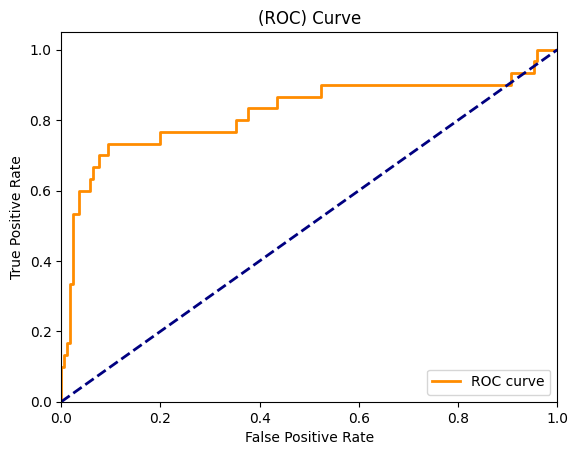

In [30]:
# Grafica de la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rnd)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**Determino 0.7 como el umbral de clasificación. Es decir, es default si la probabilidad de pertenecer a la clase 1 es mayor a 70% (0.7)**

In [31]:

y_pred_custom = (y_pred_proba_rnd >= 0.7).astype(int)


In [32]:
# probabilidades de cada cliente
probabilidades = best_random.predict_proba(df[['edad', 'ingreso_mensual', 'historial_crediticio']])

# probabilidad de que un cliente haga default (clase 1)
prob_default = probabilidades[:, 1]

# añado la probabilidad como una nueva columna en el DataFrame
df['probabilidad_default'] = prob_default

# filtro los clientes cuya probabilidad de hacer default es mayor a 0.7
clientes_default_alto = df[df['probabilidad_default'] > 0.7]

# Estos son los clientes con probabilidad mayor a 0.7
print(clientes_default_alto)

     edad  ingreso_mensual  historial_crediticio  default  \
4      60             2525                     0        1   
23     47             3531                     0        1   
29     39             5086                     1        1   
37     32             3296                     1        1   
41     69             2125                     1        0   
..    ...              ...                   ...      ...   
976    63             3355                     1        1   
981    62             3560                     0        1   
984    43             2954                     0        1   
986    39             2983                     1        0   
997    52             2036                     1        0   

     probabilidad_default  
4                0.841953  
23               0.786538  
29               0.756457  
37               0.737801  
41               0.735041  
..                    ...  
976              0.750491  
981              0.799381  
984            

In [33]:
# Exporto a dataframe
clientes_default_alto.to_csv(r'clientes_default_alto.csv', index = False)


### ***Otra opcion es predecir aquellos clientes cuya probabilidad de no hacer default es alta. (Ya que, debido al desbalance el modelo presenta un mejor rendimiento con esta clase)***

In [34]:
# probabilidades de cada cliente (tanto clase 0 como clase 1)
probabilidades = best_random.predict_proba(df[['edad', 'ingreso_mensual', 'historial_crediticio']])

# probabilidad de que un cliente NO haga default (clase 0)
prob_no_default = probabilidades[:, 0]

# probabilidad de no hacer default como una nueva columna en el DataFrame
df['probabilidad_no_default'] = prob_no_default

# Filtro los clientes cuya probabilidad de NO hacer default es mayor a 0.7
clientes_no_default_alto = df[df['probabilidad_no_default'] > 0.7]

# Ahora se pueden ver los clientes con probabilidad alta de NO hacer default (baja probabilidad de default)
print(clientes_no_default_alto)

     edad  ingreso_mensual  historial_crediticio  default  \
6      38             6123                     4        0   
9      40             9553                     2        0   
11     28             8809                     2        0   
17     20             7122                     5        0   
21     41             8506                     2        0   
..    ...              ...                   ...      ...   
972    22             9816                     4        0   
974    29             7016                     4        0   
975    43             8881                     5        0   
987    64             9291                     3        0   
994    18             7721                     4        0   

     probabilidad_default  probabilidad_no_default  
6                0.275585                 0.724415  
9                0.180144                 0.819856  
11               0.148143                 0.851857  
17               0.275653                 0.724347  
21

In [35]:
# Exporto a cv
clientes_no_default_alto.to_csv(r'clientes_no_default.csv', index = False)